# Splitting data\ creating dataset\ preprocessing #

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.train import Feature, Features, Example
from tensorflow.train import BytesList, FloatList, Int64List

In [2]:
# Importing Tensorflow data and splitting it into train, valid and test set
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_valid, x_train  = x_train_full[:5000], x_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
train_set = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(len(x_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid,y_valid)).shuffle(len(x_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(len(x_test))

In [5]:
def create_example(image,label):
    image_data = tf.io.serialize_tensor(image)
    return Example(features= Features(
    feature = {
        'image' : Feature(bytes_list = BytesList(value = [image_data.numpy()])),
        'label' : Feature(int64_list = Int64List(value = [label])),
    }))

In [6]:
for image, label in valid_set.take(1):
    print(create_example(image,label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\00

In [7]:
from contextlib import ExitStack

In [8]:
def write_tfrecords(name, dataset, n_shards = 10):
    paths = ["{}.tfrecord-{:01d}-of-{:01d}".format(name, index,n_shards) for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image,label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image,label)
            writers[shard].write(example.SerializeToString())
    return paths

In [9]:
train_filepaths = write_tfrecords("fashion_mnist_dataset/my_fashion_mnist.train",train_set)
valid_filepaths = write_tfrecords("fashion_mnist_dataset/my_fashion_mnist.valid",valid_set)
test_filepaths = write_tfrecords("fashion_mnist_dataset/my_fashion_mnist.test",test_set)

In [10]:
def preprocess(tfrecord):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord,feature_description)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape = [28,28])
    return image, example['label']

def mnsit_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, n_parse_threads=5,
                 batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [11]:
train_set = mnsit_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnsit_dataset(valid_filepaths)
test_set = mnsit_dataset(test_filepaths)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

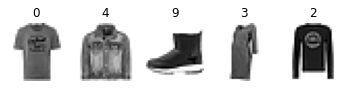

In [13]:
# Plotting samples
for x, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x[i].numpy(), cmap='binary')
        plt.axis('off')
        plt.title(str(y[i].numpy()))

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Standardizing the data with mean and std of a sample from dataset
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [16]:
# Training a model with standardizing layer
standardization = Standardization(input_shape=[28,28])
sample_image_batch = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batch.as_numpy_iterator()), axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer='nadam')

In [17]:
from datetime import datetime
import os
logs = os.path.join(os.curdir,'fashion_mnist_dataset/my_logs','run_'+datetime.now().strftime('%Y%m%d_%H%M%S'))
#logs = "fashion_mnist_dataset/my_logs" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10)
model.fit(train_set,epochs=5,validation_data=valid_set,callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 5s 3ms/step - loss: 379.0943 - accuracy: 0.8404 - val_loss: 556.1813 - val_accuracy: 0.8716
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 483.7780 - accuracy: 0.8774 - val_loss: 981.8516 - val_accuracy: 0.8740
Epoch 3/5
1719/1719 [==============================] - 4s 3ms/step - loss: 650.7222 - accuracy: 0.8911 - val_loss: 250.5944 - val_accuracy: 0.8800
Epoch 4/5
1719/1719 [==============================] - 4s 3ms/step - loss: 181.9928 - accuracy: 0.8995 - val_loss: 1154.6636 - val_accuracy: 0.8800
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 163.1356 - accuracy: 0.9090 - val_loss: 1300.4249 - val_accuracy: 0.8842


In [46]:
%tensorboard --logdir="./my_logs" --port=6006

## Text Vectorization on Movie review dataset

In [47]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/sameer/.keras/datasets/aclImdb')

In [48]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print('  '* indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print('  ' * (indent + 1) + '...')
            break
        print('  ' * (indent + 1) + filename)

aclImdb\
  README
  imdb.vocab
  imdbEr.txt
  test\
    labeledBow.feat
    urls_neg.txt
    urls_pos.txt
    neg\
      0_2.txt
      10000_4.txt
      10001_1.txt
      ...
    pos\
      0_10.txt
      10000_7.txt
      10001_9.txt
      ...
  train\
    labeledBow.feat
    unsupBow.feat
    urls_neg.txt
    ...
    neg\
      0_3.txt
      10000_4.txt
      10001_4.txt
      ...
    pos\
      0_9.txt
      10000_8.txt
      10001_10.txt
      ...
    unsup\
      0_0.txt
      10000_0.txt
      10001_0.txt
      ...


In [49]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob('*txt')]

train_pos = review_paths(path / 'train' / 'pos')
train_neg = review_paths(path / 'train' / 'neg')
test_valid_pos = review_paths(path / 'test' / 'pos')
test_valid_neg = review_paths(path / 'test' / 'neg')

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [50]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [74]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath,encoding="utf8") as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [75]:
for x, y in imdb_dataset(train_pos, train_neg).take(3):
    print(x)
    print()
    print(y)
    print()
    print('NEXT ONE')

tf.Tensor(b"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.", shape=(), dtype=string)

tf.Tensor(0, shape=(), dtype=int32)

NEXT ONE
tf.Tensor(b"Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to th

In [77]:
#%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

In [78]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative, # Since each review fits in one line '<br>',
                                          num_parallel_reads=n_read_threads) # therefore TextLineDataset()
    dataset_neg = dataset_neg.map(lambda review: (review, 0))                # used here else if not <br>
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,        # convert in to TFRecords
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [80]:
#%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

In [81]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [82]:
def preprocess(x_batch, n_words = 50):
    shape = tf.shape(x_batch) * tf.constant([1,0]) + tf.constant([0,n_words])
    z = tf.strings.substr(x_batch,0,300)
    z = tf.strings.lower(z)
    z = tf.strings.regex_replace(z, b"<br\\s*/?>", b" ")
    z = tf.strings.regex_replace(z, b"[^a-z]", b" ")
    z = tf.strings.split(z)
    return z.to_tensor(shape=shape, default_value = b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

In [83]:
from collections import Counter

def get_vocabulary(data_sample, max_size = 1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

In [84]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

In [85]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

# '0s' indicate <pad> token apart from that each word is cleaned and tokenized

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int64)>

In [86]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

In [87]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 257,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 531, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)>

In [88]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

In [89]:
# Example of 'Bag of Words'
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

1st review has 2 times word 0 id, 2 times word 1 id, 0 times word 3 id and 1 times word 4 id
2nd review has 3 times word 0 id, 0 times word 1 id, 2 times word 3 id and 0 times word 4 id
word 0 id is pad, so not into consideration

In [90]:
class BagOfWords(keras.layers.Layer):
    def __init__(self,n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype,**kwargs)
        self.n_tokens = n_tokens
    
    def call(self,inputs):
        one_hot = tf.one_hot(inputs,self.n_tokens)
        return tf.reduce_sum(one_hot,axis=1)[:,1:]

In [91]:
bag_of_words = BagOfWords(n_tokens = 4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

In [92]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words= BagOfWords(n_tokens)

In [93]:
model = keras.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])
model.fit(train_set,epochs=5,validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 21s 22ms/step - loss: 0.5439 - accuracy: 0.7164 - val_loss: 0.5136 - val_accuracy: 0.7369
Epoch 2/5
782/782 [==============================] - 19s 21ms/step - loss: 0.4715 - accuracy: 0.7707 - val_loss: 0.5107 - val_accuracy: 0.7416
Epoch 3/5
782/782 [==============================] - 19s 21ms/step - loss: 0.4222 - accuracy: 0.8030 - val_loss: 0.5160 - val_accuracy: 0.7402
Epoch 4/5
782/782 [==============================] - 19s 20ms/step - loss: 0.3524 - accuracy: 0.8517 - val_loss: 0.5294 - val_accuracy: 0.7392
Epoch 5/5
782/782 [==============================] - 18s 20ms/step - loss: 0.2687 - accuracy: 0.9004 - val_loss: 0.5794 - val_accuracy: 0.7311


Similarly to bag of words for review 1 and review 2

In [94]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs,axis=-1)
    n_words = tf.math.count_nonzero(not_pad,axis=-1,keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words,tf.float32))
    return tf.reduce_sum(inputs,axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [95]:
embedding_size = 20

model = keras.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim = n_tokens,
                          output_dim = embedding_size,
                          mask_zero = True),
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='nadam',
             metrics = ['accuracy'])
model.fit(train_set,epochs=5,validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 16s 12ms/step - loss: 0.5544 - accuracy: 0.7095 - val_loss: 0.5256 - val_accuracy: 0.7337
Epoch 2/5
782/782 [==============================] - 12s 12ms/step - loss: 0.4947 - accuracy: 0.7533 - val_loss: 0.5118 - val_accuracy: 0.7394
Epoch 3/5
782/782 [==============================] - 11s 11ms/step - loss: 0.4824 - accuracy: 0.7595 - val_loss: 0.5087 - val_accuracy: 0.7401
Epoch 4/5
782/782 [==============================] - 10s 10ms/step - loss: 0.4739 - accuracy: 0.7618 - val_loss: 0.5113 - val_accuracy: 0.7361
Epoch 5/5
782/782 [==============================] - 11s 11ms/step - loss: 0.4671 - accuracy: 0.7657 - val_loss: 0.5132 - val_accuracy: 0.7417
